# Homework 2
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [2]:
%matplotlib inline

In [23]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF**2) / (np.sqrt(2*math.pi)*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [24]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [25]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

In [26]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]


### Task 1
1. Generate a few (say, three) simulated image of a star using the simulatedImage function for different seed values, and visualize them using plotCutout. Run psfPhot and apPhot on the results of each image, and print the estimated flux.

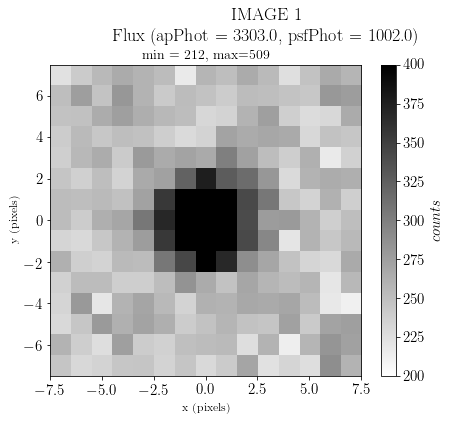

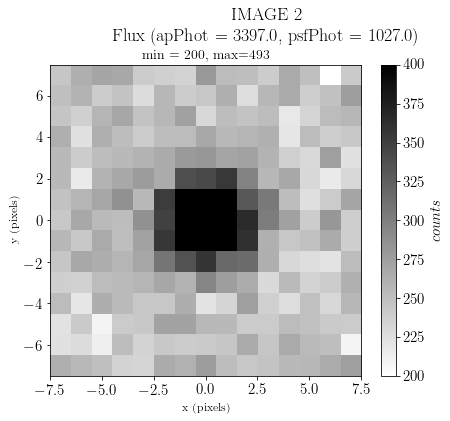

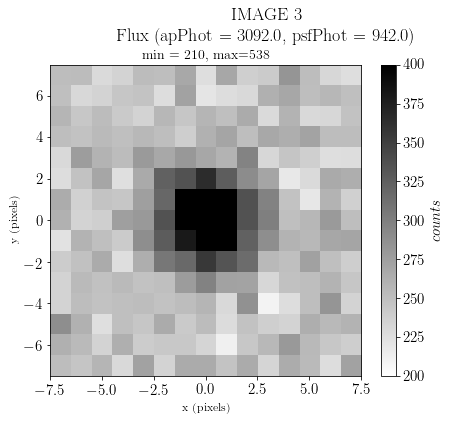

In [27]:
### Make your three simulated images here

image1=simulatedImage(1) #generating simulated images
plotCutout(image1) #plottig simulated image
plt.suptitle("IMAGE 1 \n Flux (apPhot = %.1f, psfPhot = %.1f)" %(apPhot(image1),(psfPhot(image1))))

image2=simulatedImage(10)
plotCutout(image2)
plt.suptitle("IMAGE 2 \n Flux (apPhot = %.1f, psfPhot = %.1f)" %(apPhot(image2),(psfPhot(image2))))

image3=simulatedImage(100)
plotCutout(image3)
plt.suptitle("IMAGE 3 \n Flux (apPhot = %.1f, psfPhot = %.1f)" %(apPhot(image3),(psfPhot(image3))))

plt.show()




### Task 2
2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

In [28]:
def centerPhot(image):
    #### DEFINE YOUR FUNCTION HERE ####
    image=image-skyBg #background subtraction
    shape=image.shape 
    center=np.int((shape[0]-1)/2) #location of central pixel
    centerPhotImage=image[center][center] #extracting value of central pixel
    return centerPhotImage

In [29]:
print("IMAGE1")
print("Flux using centerPhot = %.1f"%(centerPhot(image1)))

print("IMAGE2")
print("Flux using centerPhot = %.1f"%(centerPhot(image2)))

print("IMAGE2")
print("Flux using centerPhot = %.1f"%(centerPhot(image3)))


IMAGE1
Flux using centerPhot = 259.0
IMAGE2
Flux using centerPhot = 243.0
IMAGE2
Flux using centerPhot = 288.0


## Comment on the result!
`Q2 Answer:` **__The central pixel value is a biased estimator of the total magnitude of the object. This value is lower than the true magnitude as we are not taking into account the pixels surrounding the central pixel. Star light from the sky is scattered through the atmosphere and thus all the photons donot reach the central pixel. Everytime, different number of photons reach the central pixel due to which this estimator is not unbiased.__**

### Task 3 / 4

#### Solve tasks 3/4 here
3. Generate a thousand different simulated images using simulatedImage, and compute centerPhot, psfPhot, and apPhot for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using np.average) and standard deviation (with np.std).

In [30]:
psf=np.zeros(1000)
ap=np.zeros(1000)
cen=np.zeros(1000) 
for i in range(1000):
    img=simulatedImage(i) #image simulation 
    psf[i]=psfPhot(img) #flux of images using psfPhot
    ap[i]=apPhot(img) #flux of images using apPhot
    cen[i]=centerPhot(img) #flux using centerPhot

/home/varun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


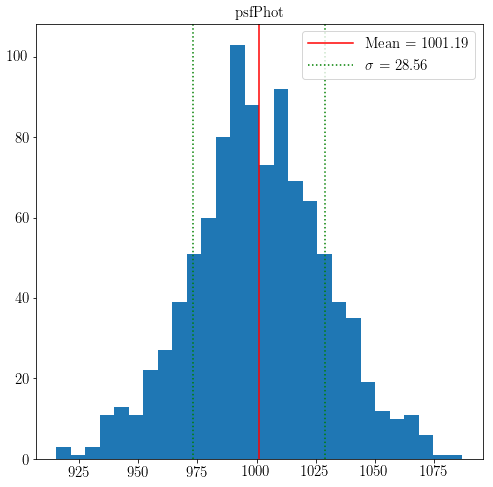

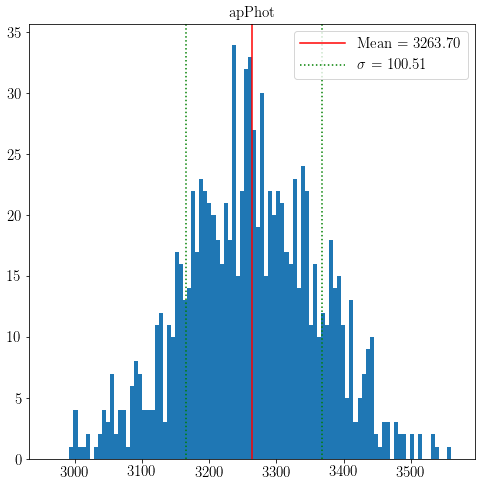

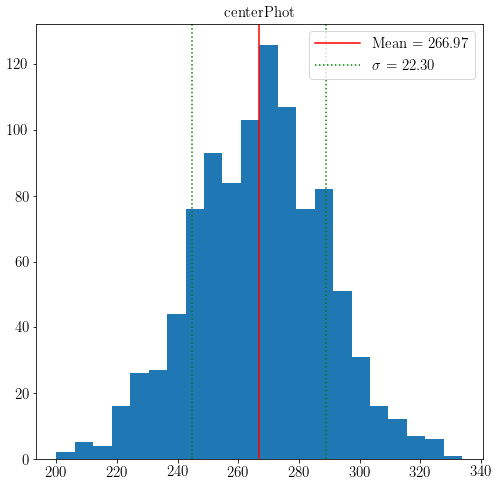

In [31]:
def hist(flux,calib=False,title=""): #function for plotting histogram, norm=True to turn on calibration Atrue/Amean
    avg=np.average(flux) #average of fluxes
    if calib is True :
        flux=flux*Atrue/avg #calibration to true flux
        
    avg=np.average(flux) #if calibration is true, set avg to mean of new (calibrated) flux
    std=np.std(flux) #
    bins = np.linspace(avg-3*std, avg+3*std, std+1)
    fig, ax = plt.subplots(figsize=(8,8))
    n, bins, patches = ax.hist(flux, bins)
    q1 = np.percentile(flux, 15.9)
    q2 = np.percentile(flux, 84.1)
    plt.axvline(x=avg,color='r',label='Mean = %.2f'%avg)
    plt.axvline(x=q1,color='g',linestyle=':',label='$\sigma$ = %.2f'%std)
    plt.axvline(x=q2,color='g',linestyle=':')
    plt.title("%s"%title)
    plt.legend()

hist(psf,title="psfPhot")
hist(ap,title="apPhot")
hist(cen,title="centerPhot")

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by Atrue/Amean (where Amean is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

/home/varun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


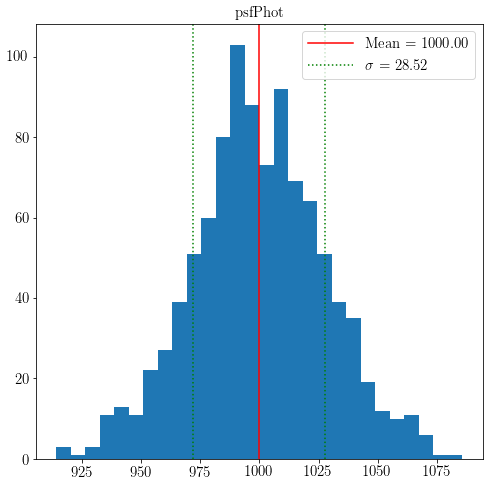

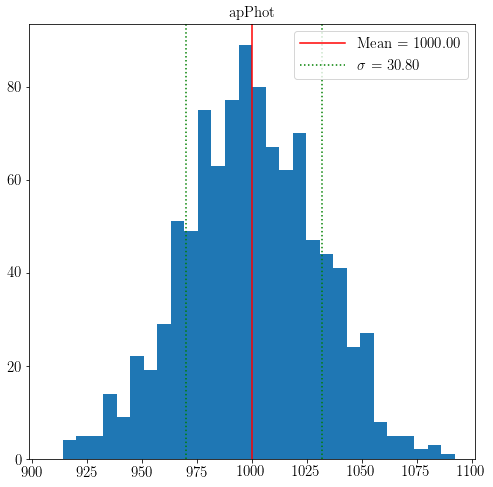

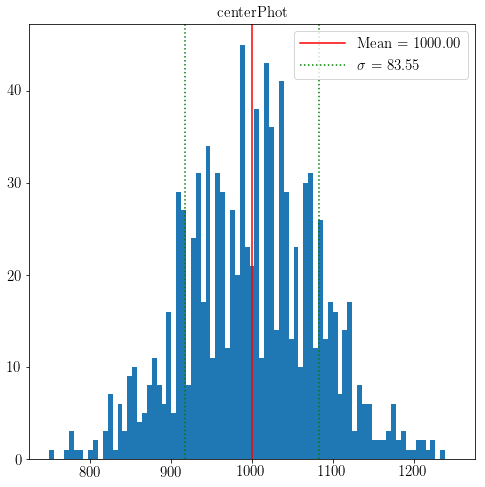

In [32]:
hist(psf,True,title="psfPhot")
hist(ap,True,title="apPhot")
hist(cen,True,title="centerPhot")

`Question 4 Answer:` *__After the calibration, the widths of psfPhot has decreased, and increased for apPhot & centerPhot. Upon further observation we notice that the standard deviations are changed by a factor of Atrue/Amean as well. Hence, the deviations are now comparable and we see that psfPhot gives the least amount of deviation. psfPhot is the narrowest because it includes the maximum source photons (but also more noise), and hence has the highest S/N value out of the three functions. psfPhot is the only unbiased estimator as it takes into account all the photons that have been scattered by the atmosphere, whereas apPhot and centerPhot do not.__* 